<a href="https://colab.research.google.com/github/mahmoudkanazzal/A-strategy-for-residual-component-based-multiple-structured-dictionary-learning/blob/main/DEMO_radar24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import torch

## Functions

In [ ]:
# convert complex to real
def c2r(z):
    z_real = z.real
    z_imag = z.imag
    z_bar = np.hstack((z_real, z_imag))
    return np.array(z_bar)

### Generate training and test data

In [ ]:
# Define parameters K, sigma_alpha_squared, and sigma_noise_squared [Question (2)]
K = 32
sigma_alpha_squared = 250
sigma_noise_squared=10

# Function to generate a complex alpha based on Swerling model
def generate_alpha(sigma_alpha_squared):
    real_part = np.random.normal(0, np.sqrt(sigma_alpha_squared / 2))
    imag_part = np.random.normal(0, np.sqrt(sigma_alpha_squared / 2))
    return real_part + 1j * imag_part

def generate_noise(sigma_noise_squared, s):

    sigma_noise = np.sqrt(sigma_noise_squared)

    real_noise = np.random.normal(0, sigma_noise, s.shape)
    imaginary_noise = np.random.normal(0, sigma_noise, s.shape)

    complex_noise = real_noise + 1j * imaginary_noise

    return complex_noise

# Here we specify the vlaues of f_dT_c [Question (1)]

# Function to generate s and y pair
def generate_sy_pair(K, label):
    # Generate random phase for the s_k signal
    theta_K = 2 * np.pi * np.random.uniform(0, 1, K)

    # Create the s signal
    s = (1/np.sqrt(K)) * np.exp(1j * theta_K)

    # noise realization (environment noise)
    n = generate_noise(sigma_noise_squared, s)

    if label>0: # if there is an object in the view area
        # sample a value for f_dT_c
        f_dT_c = np.random.normal(0, 1)*0.001
        # Create the Phi(f_d) diagonal matrix
        phi_diag = np.exp(1j * 2 * np.pi * f_dT_c * np.arange(K))
        Phi = np.diag(phi_diag)

        # Create y signal with alpha from the Swerling model
        alpha = generate_alpha(sigma_alpha_squared)

        y = alpha * Phi @ s + n
    else: # if there is no object
        y =  n
    # convert complex to real, and concatinate
    y_bar=c2r(y)

    # calculate z:
    z = y * np.conjugate(s)
    z_bar=c2r(z)
    s=np.array(s)
#     print(s.shape)
    # return s, y, y_bar,z, and z_bar, as matrics (bar means converted to real)
    return np.array(s), np.array(y), np.array(y_bar), np.array(z), np.array(z_bar)

# here, we specify the size of the whole data set [Question (3)]

# NN: the number of signals in the whole set. Those will be divided later into training and testing signals.
# We later use the fucntion train_test_split to split this into training and test sets with a controllable ratio (for example 0.2 means
# 80% of these vectors are assigned to the training set and 20% are for the test set.)

# Initialize empty arrays to store s, y, y_bar, z, z_bar, and labels
NN=30000
s_arr = np.empty((NN, K), dtype=complex)
y_arr = np.empty((NN, K), dtype=complex)
z_arr = np.empty((NN, K), dtype=complex)
y_bar_arr = np.empty((NN, K*2))
z_bar_arr = np.empty((NN, K*2))
label_arr = np.empty(NN, dtype=int)

for i in range(NN):

    # randomly deicde if there is an object (1) or not (0)
    label_i = random.choice([0, 1])

    # for this realziation, get s, y, y_bar, z, and z_bar
    si, yi, y_bari, zi, z_bari=generate_sy_pair(K, label_i)
        # Store si, yi, yi_bar, z_i, zi_bar, and blabel_i in their respective arrays
    s_arr[i, :] = si
    y_arr[i, :] = yi
    y_bar_arr[i, :] = y_bari
    z_arr[i, :] = zi
    z_bar_arr[i, :] = z_bari
    label_arr[i] = label_i


## First: Old (With preprocessing) with PyTorch

In [ ]:
# This is the creation of the FF model architecture [Question (4)]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FeedFowardClassifier(nn.Module):
    def __init__(self):
        super(FeedFowardClassifier, self).__init__()
        # Step 2: Add one or more fully connected layers.
        self.fc1 = nn.Linear(64, 32).double() # You can add more layers if you like
        self.fc2 = nn.Linear(32, 2).double()

    def forward(self, x1):
        # Fully connected layers with activations
        x = F.relu(self.fc1(x1))

        # Output layer with softmax
        out = self.fc2(x)

        return out

In [ ]:
model = FeedFowardClassifier()
# print(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
Xtr, Xts, Ltr, Lts = train_test_split(z_bar_arr, label_arr, test_size=0.2, random_state=42)
Xtr=torch.tensor(Xtr)
Xts=torch.tensor(Xts)
Ltr=torch.tensor(Ltr)
Lts=torch.tensor(Lts)
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(Xtr, Ltr)
data_loader = DataLoader(dataset, batch_size=8192, shuffle=True)

In [ ]:
# Xts The size of this array is the number of trails for the testing (inferenc) [Question (5)]

In [ ]:
# num_epochs=1000 this refers to the number epochs the ML model is trained over the training data, i.e., having a full
# pass over the training dataset (3)

In [ ]:
num_epochs=1000
for epoch in range(1000):
    for data, labels in data_loader:  # Assuming you have a DataLoader named train_loader
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
with torch.no_grad():
    Xtest = Xts.to("cpu")
    outputs = model(Xtest)

_, predicted = torch.max(outputs, 1)

# Assuming Labeltest is a torch tensor; if not, convert it
if not isinstance(Lts, torch.Tensor):
    Labeltest = torch.tensor(Lts)

correct = (predicted.cpu() == Lts).sum().item()
total = Lts.size(0)
accuracy = correct / total

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.23%


In [ ]:
model.eval()

with torch.no_grad():
    # Assuming Xtest and Ytest are torch tensors; if they're not, convert them.
    Xtest = Xtest.to("cpu")
    outputs = model(Xtest)
    # Get the predicted probabilities for the positive class (assuming it's the second column of the outputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr1, tpr1, thresholds = roc_curve(Lts, probs)

## Second: End-to-end DNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
def prep(data):
  # Extracting real and imaginary parts
  real_parts = [num.real for num in data]
  imaginary_parts = [num.imag for num in data]
  formatted_data=[]
  for i in range(len(real_parts)):
    formatted_data.append([real_parts[i],imaginary_parts[i]])

  # Convert to a PyTorch tensor
  input_tensor = torch.tensor(formatted_data, dtype=torch.float64)
  return input_tensor

class FistLayers(nn.Module):
    def __init__(self, lambda_val=0.000001, bias1=2.3787):
        super(FistLayers, self).__init__()

        self.lambda_val = lambda_val
        self.bias1 = torch.tensor(bias1, dtype=torch.float64)  # Use double precision

        self.mu = 1 / ((self.lambda_val ** 2) * 4 * self.sigmoid_sec(self.bias1))

        self.W1 = nn.Parameter(torch.tensor([[lambda_val, lambda_val],
                                             [-lambda_val, -lambda_val],
                                             [lambda_val, -lambda_val],
                                             [-lambda_val, lambda_val]], dtype=torch.float64), requires_grad=True)  # Use double precision

        self.b1 = nn.Parameter(torch.tensor([bias1, bias1, bias1, bias1], dtype=torch.float64).view(1, 4, 1), requires_grad=True)  # Use double precision
        self.W2 = nn.Parameter(torch.tensor([self.mu, self.mu, -self.mu, -self.mu], dtype=torch.float64), requires_grad=True)  # Use double precision

    def sigmoid_sec(self, x):
        sigm = torch.sigmoid(x)
        return sigm * (1 - sigm) * (1 - 2 * sigm)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 2, 1)  # Reshape to [batch_size, 2, 1]
        z1 = torch.bmm(self.W1.unsqueeze(0).repeat(batch_size, 1, 1), x) + self.b1
        a1 = torch.sigmoid(z1)
        z2 = torch.bmm(self.W2.view(1, 1, 4).repeat(batch_size, 1, 1), a1)
        return z2.squeeze(2).squeeze(1)

class BatchComplexFistLayers(nn.Module):
    def __init__(self, lambda_val=0.000001, bias1=2.3787):
        super(BatchComplexFistLayers, self).__init__()

        # Instance of the FistLayers to handle the components of the complex product
        self.multiplier = FistLayers(lambda_val, bias1)

    def forward(self, complex_arr1, complex_arr2):
        batch_size = complex_arr1.shape[0]

        # Separate the real and imaginary parts
        real1, imag1 = complex_arr1[:, :, 0], -complex_arr1[:, :, 1]
        real2, imag2 = complex_arr2[:, :, 0], complex_arr2[:, :, 1]

        # Calculate the components of the product
        real_product = self.multiplier(torch.stack([real1, real2], dim=2).view(-1, 2)) - \
                       self.multiplier(torch.stack([imag1, imag2], dim=2).view(-1, 2))
        imag_product = self.multiplier(torch.stack([real1, imag2], dim=2).view(-1, 2)) + \
                       self.multiplier(torch.stack([imag1, real2], dim=2).view(-1, 2))

        # Reshape and stack the results
        real_product = real_product.view(batch_size, 32)
        imag_product = imag_product.view(batch_size, 32)
        result = torch.cat([real_product, imag_product], dim=1)

        return result

class FeedFowardClassifier(nn.Module): # thewholemodel
    def __init__(self):
        super(FeedFowardClassifier, self).__init__()

        # Step 1: inital layers
        self.complex_multiplier = BatchComplexFistLayers()

        # Step 2: Add one or more fully connected layers.
        self.fc1 = nn.Linear(64, 32).double() # You can add more layers if you like
        self.fc2 = nn.Linear(32, 2).double()

    def forward(self, x1, x2):
        # Complex multiplication
        x = self.complex_multiplier(x1, x2)

        # Fully connected layers with activations
        x = F.relu(self.fc1(x))

        # Output layer with softmax
        out = self.fc2(x)

        return out

In [ ]:
S=[]
Y=[]
for i in range(len(s_arr)):
  S.append(prep(s_arr[i]))
  Y.append(prep(y_arr[i]))

Xtr, Xts, Ytr, Yts, Ltr, Lts = train_test_split(S, Y, label_arr, test_size=0.2, random_state=42)
Xtr=torch.stack(Xtr)
Xts=torch.stack(Xts)
Ytr=torch.stack(Ytr)
Yts=torch.stack(Yts)
Ltr=torch.tensor(Ltr)
Lts=torch.tensor(Lts)
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(Xtr, Ytr, Ltr)
data_loader = DataLoader(dataset, batch_size=8192, shuffle=True)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

model = FeedFowardClassifier().to(device)  # Transfer the model to GPU
for param in model.complex_multiplier.parameters():
    param.requires_grad = False
# print(model.complex_multiplier.multiplier.W1)
# print(model.complex_multiplier.multiplier.W2)
# print(model.complex_multiplier.multiplier.b1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 1000

for epoch in range(num_epochs):
    for batch_x1, batch_x2, batch_y in data_loader:
        # Transfer data to GPU
        batch_x1, batch_x2, batch_y = batch_x1.to(device), batch_x2.to(device), batch_y.to(device)

        outputs = model(batch_x1, batch_x2)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Training on GPU


In [ ]:
with torch.no_grad():
    Xtest = Xts.to(device)
    Ytest = Yts.to(device)
    outputs = model(Xtest, Ytest)


_, predicted = torch.max(outputs, 1)


# Assuming Labeltest is a torch tensor; if not, convert it
if not isinstance(Lts, torch.Tensor):
    Labeltest = torch.tensor(Lts)

correct = (predicted.cpu() == Lts).sum().item()
total = Lts.size(0)
accuracy = correct / total

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 86.55%


In [ ]:
model.eval()
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)


with torch.no_grad():
    # Assuming Xtest and Ytest are torch tensors; if they're not, convert them.
    Xtest = Xtest.to(device)
    Ytest = Ytest.to(device)
    outputs = model(Xtest, Ytest)
    # Get the predicted probabilities for the positive class (assuming it's the second column of the outputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr2, tpr2, thresholds = roc_curve(Lts, probs)

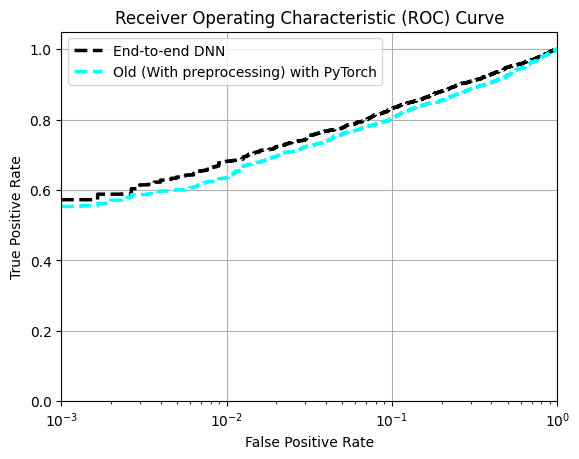

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr2, tpr2, color='black', linestyle='--',lw=2.5, label='End-to-end DNN')
plt.plot(fpr1, tpr1, color='cyan', linestyle='--',lw=2.5, label='Old (With preprocessing) with PyTorch')

# Set x-axis limits on a logarithmic scale
plt.xscale('log')
plt.xlim([1e-3, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig("result_oct16.png", dpi=150)
plt.show()

1. What are the vlaues of f_d and T_c? or the product f_d*T_c (the normlized f_d is in [0,1]). I suppose that the reuslts in Fig. 4 are based on a random selection of f_d. WHat are the speciifcaitons of this randomness?
2. What is the value of sigma_alpha_squared or sigma_noise_squared (given that SNR=10=sigma_alpha^2/sigma_noise^2)?
3. How many data points are used in the experiemnt? what is the train/test split ratio?
4. What are the architectral specifcations of the feedforward classifier model? (number of layers/ learning rate, etc.)
5. The number of trials used in averaging the results in Fig 4